## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from torch.utils.data import Subset
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time


# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
# class TinyNeuralNetwork(nn.Module):
#     def __init__(self, input_shape=28*28, num_classes=10):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Flatten(),  # Converts image to a vector
#             nn.Linear(input_shape, num_classes)  # Fully connected layer
#         )
        
#     def forward(self, inp):
#         out = self.model(inp)
#         return out

class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 300),
            nn.BatchNorm1d(300),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
            
        )
  
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
device = 'cpu'
model = TinyNeuralNetwork().to(device)

torchsummary.summary(model, (28*28,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
       BatchNorm1d-3                  [-1, 300]             600
           Dropout-4                  [-1, 300]               0
              ReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 100]          30,100
           Dropout-7                  [-1, 100]               0
              ReLU-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
       LogSoftmax-10                   [-1, 10]               0
Total params: 267,210
Trainable params: 267,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.02
Estimated T

Your experiments come here:

In [9]:
model = TinyNeuralNetwork() #.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
error = nn.CrossEntropyLoss()

# Train Function

In [13]:
from torch.autograd import Variable
model = TinyNeuralNetwork()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
error = nn.CrossEntropyLoss() 

# Обучение модели
count = 0

loss_train_1 = []
loss_test_1 = []

accuracy_train_1 = []
accuracy_test_1 = []

for epoch in range(30):
    loss_train_epoch = []
    loss_test_epoch = []
    accuracy_train_epoch = []
    accuracy_test_epoch = []
    
    model.train(True)
    for i, (images, labels) in enumerate(train_loader):
           
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = error(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted1 = torch.max(outputs.data, 1)[1]
            total1 = len(labels)
            correct1 = (predicted1 == labels).sum()
            accuracy1 = 100 * correct1 / float(total1)
            accuracy_train_epoch.append(accuracy1.item())
            loss_train_epoch.append(loss.item())
            count += 1

    model.train(False) 
    with torch.no_grad():
        correct2 = 0
        total2 = 0
        for test_images, labels in test_loader: 
            
            test_images, labels = test_images.to(device), labels.to(device)
            
            outputs = model(test_images)
            loss_ = error(outputs, labels)
            predicted2 = torch.max(outputs.data, 1)[1]

            total2 += len(labels)
            correct2 += (predicted2 == labels).sum()
            loss_test_epoch.append(loss_.item())

        accuracy2 = 100 * correct2 / float(total2)
        accuracy_test_epoch.append(accuracy2.item())  
    
    accuracy_train_1.append(np.mean(accuracy_train_epoch))
    accuracy_test_1.append(np.mean(accuracy_test_epoch))
    loss_train_1.append(np.mean(loss_train_epoch))
    loss_test_1.append(np.mean(loss_test_epoch))
    print('Epoch: {}  Loss: {}  Accuracy: {}%'.format(epoch+1, loss_test_1[-1], accuracy2))


Epoch: 1  Loss: 0.42933330312371254  Accuracy: 84.38999938964844%
Epoch: 2  Loss: 0.4464716449379921  Accuracy: 83.44000244140625%
Epoch: 3  Loss: 0.39722914397716524  Accuracy: 85.0199966430664%
Epoch: 4  Loss: 0.3725716654211283  Accuracy: 86.13999938964844%
Epoch: 5  Loss: 0.35245832800865173  Accuracy: 86.83999633789062%
Epoch: 6  Loss: 0.35206481255590916  Accuracy: 86.81999969482422%
Epoch: 7  Loss: 0.34454305097460747  Accuracy: 87.2300033569336%
Epoch: 8  Loss: 0.3533564046025276  Accuracy: 86.62999725341797%
Epoch: 9  Loss: 0.3499404598027468  Accuracy: 86.98999786376953%
Epoch: 10  Loss: 0.331184290163219  Accuracy: 87.73999786376953%
Epoch: 11  Loss: 0.32926512472331526  Accuracy: 87.80999755859375%
Epoch: 12  Loss: 0.33133954238146546  Accuracy: 87.69999694824219%
Epoch: 13  Loss: 0.3299170175567269  Accuracy: 87.63999938964844%
Epoch: 14  Loss: 0.32045292388647795  Accuracy: 88.37999725341797%
Epoch: 15  Loss: 0.3172508627176285  Accuracy: 88.05999755859375%
Epoch: 16  Los

# Visuals

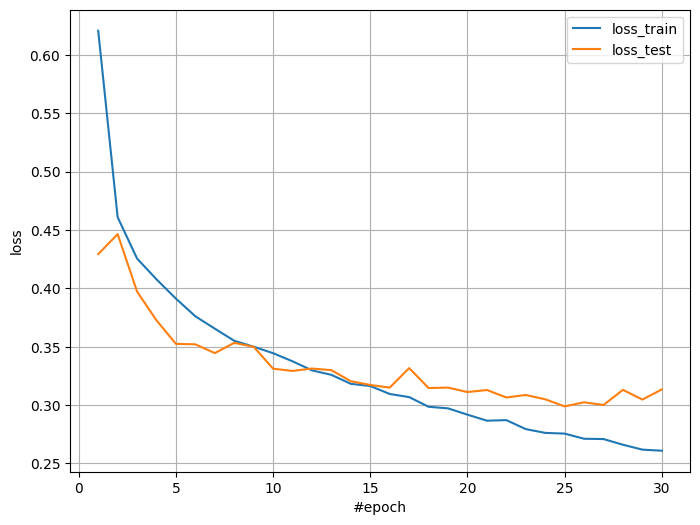

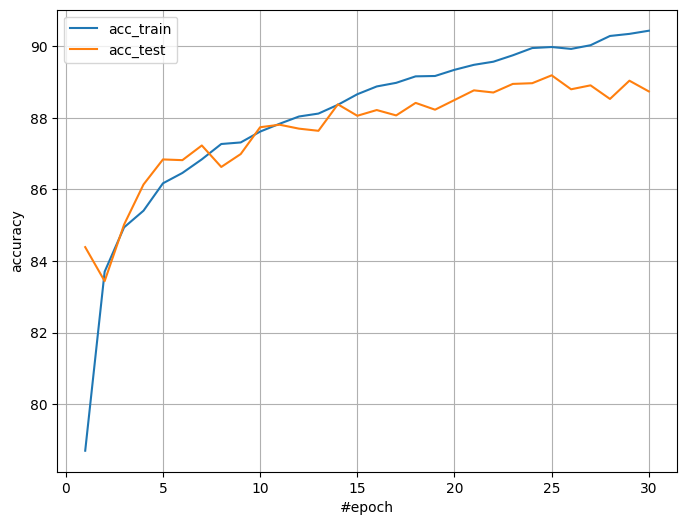

In [14]:
# Потери
plt.figure(figsize=(8, 6))
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(np.arange(1,31), loss_train_1, label = 'loss_train')
plt.plot(np.arange(1,31), loss_test_1, label = 'loss_test')
plt.legend()
plt.grid(True)
plt.show()

# Точность
plt.figure(figsize=(8, 6))
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot( np.arange(1,31), accuracy_train_1, label = 'acc_train')
plt.plot( np.arange(1,31), accuracy_test_1, label = 'acc_test')
plt.legend()
plt.grid(True)
plt.show()

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [17]:
import torch.nn as nn

class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  
            nn.Linear(784, 392),  
            nn.ReLU(),  
            nn.Linear(392, 10),  
            nn.LogSoftmax(dim=1)  
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

In [18]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
              ReLU-3                  [-1, 392]               0
            Linear-4                   [-1, 10]           3,930
        LogSoftmax-5                   [-1, 10]               0
Total params: 311,650
Trainable params: 311,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.19
Estimated Total Size (MB): 1.20
----------------------------------------------------------------


In [19]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [24]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)  
        for X_batch, y_batch in train_loader:
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)  
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)

                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append((y_pred == y_batch).float().mean().item())

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}, Time: {time.time() - start_time:.2f}s")

    return train_loss, val_loss, val_accuracy


## Reduce the size of the dataset

In [25]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

val_size = 0.1
val_inds = subset_ind(fmnist_dataset_train, val_size)

train_dataset = Subset(fmnist_dataset_train, val_inds)

len(train_dataset)

6000

In [26]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [27]:
n_epochs = 75
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1/75, Train Loss: 0.9955, Val Loss: 0.6685, Val Accuracy: 0.7590, Time: 5.90s
Epoch 2/75, Train Loss: 0.5929, Val Loss: 0.5983, Val Accuracy: 0.7893, Time: 5.88s
Epoch 3/75, Train Loss: 0.5125, Val Loss: 0.5370, Val Accuracy: 0.8128, Time: 6.19s
Epoch 4/75, Train Loss: 0.4734, Val Loss: 0.4997, Val Accuracy: 0.8265, Time: 6.25s
Epoch 5/75, Train Loss: 0.4278, Val Loss: 0.5013, Val Accuracy: 0.8274, Time: 6.25s
Epoch 6/75, Train Loss: 0.4017, Val Loss: 0.4818, Val Accuracy: 0.8305, Time: 6.04s
Epoch 7/75, Train Loss: 0.3816, Val Loss: 0.5022, Val Accuracy: 0.8281, Time: 6.00s
Epoch 8/75, Train Loss: 0.3695, Val Loss: 0.4894, Val Accuracy: 0.8276, Time: 5.89s
Epoch 9/75, Train Loss: 0.3477, Val Loss: 0.4714, Val Accuracy: 0.8370, Time: 5.94s
Epoch 10/75, Train Loss: 0.3338, Val Loss: 0.4694, Val Accuracy: 0.8416, Time: 6.24s
Epoch 11/75, Train Loss: 0.3196, Val Loss: 0.4903, Val Accuracy: 0.8327, Time: 6.45s
Epoch 12/75, Train Loss: 0.3166, Val Loss: 0.4577, Val Accuracy: 0.8420, T

In [28]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
    

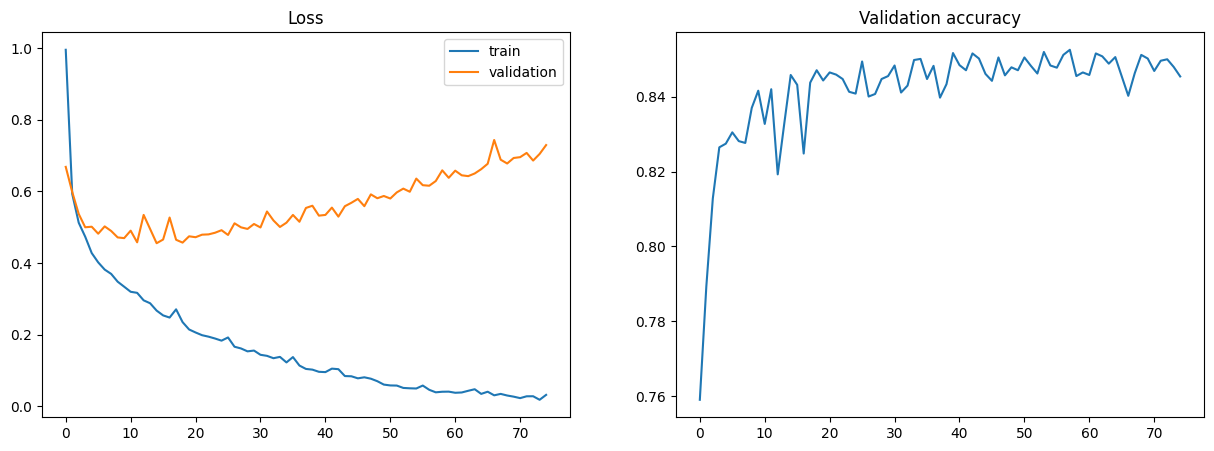

In [29]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Мы видим разницу в потерях, что является заметным признаком перетренированности

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [30]:
import torch.nn as nn

class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(392, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

In [31]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 392]         307,720
              ReLU-4                  [-1, 392]               0
           Dropout-5                  [-1, 392]               0
            Linear-6                   [-1, 10]           3,930
        LogSoftmax-7                   [-1, 10]               0
Total params: 311,650
Trainable params: 311,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.19
Estimated Total Size (MB): 1.21
----------------------------------------------------------------


In [32]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [33]:
n_epochs = 75

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1/75, Train Loss: 1.2001, Val Loss: 0.7651, Val Accuracy: 0.7271, Time: 5.92s
Epoch 2/75, Train Loss: 0.7599, Val Loss: 0.6451, Val Accuracy: 0.7671, Time: 6.60s
Epoch 3/75, Train Loss: 0.6826, Val Loss: 0.6015, Val Accuracy: 0.7737, Time: 6.05s
Epoch 4/75, Train Loss: 0.6499, Val Loss: 0.5711, Val Accuracy: 0.7920, Time: 6.08s
Epoch 5/75, Train Loss: 0.6162, Val Loss: 0.5694, Val Accuracy: 0.7959, Time: 6.24s
Epoch 6/75, Train Loss: 0.5978, Val Loss: 0.5310, Val Accuracy: 0.8078, Time: 6.01s
Epoch 7/75, Train Loss: 0.5815, Val Loss: 0.5272, Val Accuracy: 0.8115, Time: 5.97s
Epoch 8/75, Train Loss: 0.5597, Val Loss: 0.5146, Val Accuracy: 0.8188, Time: 5.59s
Epoch 9/75, Train Loss: 0.5492, Val Loss: 0.5181, Val Accuracy: 0.8115, Time: 5.58s
Epoch 10/75, Train Loss: 0.5319, Val Loss: 0.5018, Val Accuracy: 0.8141, Time: 5.60s
Epoch 11/75, Train Loss: 0.5365, Val Loss: 0.4984, Val Accuracy: 0.8252, Time: 5.61s
Epoch 12/75, Train Loss: 0.5099, Val Loss: 0.4826, Val Accuracy: 0.8293, T

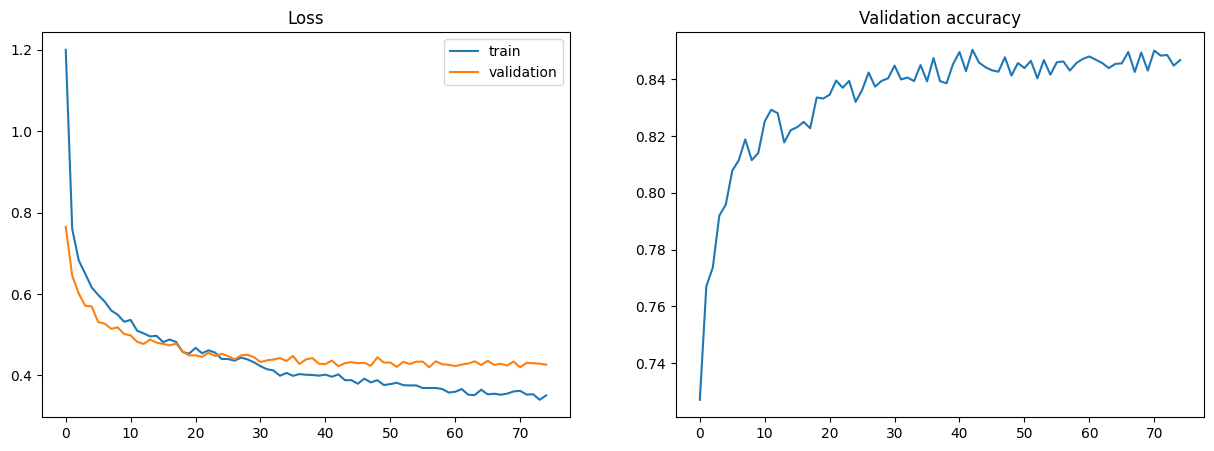

In [34]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:


При анализе графиков потерь становится очевидным, что использование методов регуляризации уменьшает переобучение. Это особенно ясно при сравнении кривых потерь для наборов данных обучения и проверки. В переоснащенной модели кривые потерь при обучении и проверке значительно расходятся. Переоснащение произошло потому, что набор обучающих данных был намеренно сокращен до 6000 выборок, в то время как модель имела более 300 000 параметров, что привело к запоминанию данных моделью. После введения в модель отсева результаты улучшились, а разрыв между потерями при обучении и валидации стал менее выраженным.